<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


    
# 31_BasicModelEvaluation

#### Demonstrate posterior predictive checks and info criteria

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    + [Describe Dataset](#Describe-Dataset)


+ [Reload Models and Traces](#Reload-Models-and-Traces)
    + [Reload PyMC3 model and traces](#Reload-PyMC3-model-and-traces)
    + [Reload PyStan fitted model](#Reload-PyStan-fitted-model)


+ [Posterior Predictive Checks on Training Data](#Posterior-Predictive-Checks-on-Training-Data)
    + [Calculate Posterior Samples](#Calculate-Posterior-Samples)
    + [Eyeballing: Plot the yhat Distributions](#Eyeballing:-Plot-the-yhat-Distributions)
    + [Eyeballing: Calculate Coverage](#Eyeballing:-Calculate-Coverage)
    + [MSE and R-squared](#MSE-and-R-squared)
    + [KS test](#KS-test)  


---

# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
# general packages
import sqlite3
from convenience_functions import *
from ipywidgets import interactive, fixed
from itertools import combinations

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize
from scipy.stats import ks_2samp
import statsmodels.api as sm

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

## Local Functions

In [3]:
# none

## Load Data

In [4]:
cnxsql = sqlite3.connect('data/car_emissions.db')
dfs = pd.read_sql('select * from cars_post_exclusions_2sd', cnxsql, index_col=None)

In [5]:
## convert sqlite bool storage (as ints) back to bools
for ft in ['parent_is_vw', 'mfr_is_vw', 'is_tdi']:
    dfs[ft] = dfs[ft].astype(bool)

In [6]:
custom_describe(dfs)

(2593, 13)


,1653,835,763,count,mean,std,min,25%,50%,75%,max,dtype
emissions_nox_mgkm,12,36,32,2593,37.32,17.9,1,23.000000,35.000000,51.000000,76,float64
parent_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
mfr_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
parent,daimler-ag,bmw,bmw,2593,NaN,NaN,aston,NaN,NaN,NaN,volksw,object
mfr,mercedes-benz,bmw,bmw,2593,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
trans,auto,semiauto,auto,2593,NaN,NaN,auto,NaN,NaN,NaN,semiau,object
fuel_type,petrol,petrol,petrol,2593,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
is_tdi,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
metric_combined,-0.0728208,0.80692,0.220426,2593,-0.00,0.5,-0.685973,-0.339409,-0.152797,0.167108,2.75301,float64
metric_extra_urban,-0.0751821,0.47462,0.0728415,2593,0.00,0.5,-0.47696,-0.180913,-0.075182,0.093988,21.5997,float64


##### Declare feats for use

In [7]:
fts_cat = ['parent_is_vw', 'mfr_is_vw', 'parent', 'mfr', 'trans', 'fuel_type', 'is_tdi']
fts_cat_smp = ['mfr_is_vw','trans','fuel_type','is_tdi']
fts_num = ['metric_combined', 'metric_extra_urban', 'metric_urban_cold'
           ,'engine_capacity', 'emissions_co_mgkm']
fts_num_smp = ['metric_combined', 'engine_capacity', 'emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

## Describe dataset

+ The dataset is 2593 rows, with 12 exog features, 1 endog feature.
+ These are observations of car emissions tests, one row per car.
+ You can read off the basic distributional statistics of the features in the table above. Numeric features have been standardized according to [Gelman's 2sd principle](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
+ I have selected these particular 12 features to work with. Some are derivatives of original features.

We have the following features to choose from:

```
+ Categoricals:
    + `trans`     - the car transmission, simplified to 'auto', 'semiauto', 'manual'
    + `fuel_type` - the car power supply, simplified to 'petrol', 'diesel'
    + `parent`    - the parent company of the car manufacturer, 20 values
    + `mfr`       - the car manufacturer, 38 values

+ Booleans:
    + `parent_is_vw` - if the parent company of the car manufacturer is Volkswagen
    + `mfr_is_vw`    - if the car manufacturer is Volkswagen
    + `is_tdi`       - (processed feature) if the car engine type is a turbo diesel
    
+ Numerics:
    + `metric_combined`    - a score for fuel efficiency in combined driving
    + `metric_extra_urban` - a score for fuel efficiency in an extra-urban driving
    + `metric_urban_cold`  - a score for fuel efficiency in an urban setting, cold start
    + `emissions_co_mgkm`  - a count of CO particulates emitted mg/km
    
+ Numeric endogenous feature:
    + `emissions_nox_mgkm` - a count of NOx particulates emitted mg/km    
```

For the purposes of this Notebook, the final feature mentioned `emissions_nox_mgkm` will be used as the _endogenous_ / _dependent_ / _output_ feature of the linear models. All other features may be used as _exogenous_ / _independent_ / _input_ features.

##### Create design matrices

In [8]:
fml_all = '{} ~ '.format(ft_endog) + ' + '.join(fts_num_smp + fts_cat_smp)
fml_all

'emissions_nox_mgkm ~ metric_combined + engine_capacity + emissions_co_mgkm + mfr_is_vw + trans + fuel_type + is_tdi'

In [9]:
(mx_en, mx_ex) = pt.dmatrices(fml_all, dfs, return_type='dataframe', NA_action='raise')
custom_describe(mx_ex, 2, )

(2593, 9)


,1731,1033,count,mean,std,min,25%,50%,75%,max,dtype
Intercept,1.000000,1.000000,2593,1.00,0.00,1.000000,1.000000,1.000000,1.000000,1.000000,float64
mfr_is_vw[T.True],0.000000,0.000000,2593,0.04,0.20,0.000000,0.000000,0.000000,0.000000,1.000000,float64
trans[T.manual],0.000000,1.000000,2593,0.49,0.50,0.000000,0.000000,0.000000,1.000000,1.000000,float64
trans[T.semiauto],0.000000,0.000000,2593,0.12,0.32,0.000000,0.000000,0.000000,0.000000,1.000000,float64
fuel_type[T.petrol],0.000000,0.000000,2593,0.50,0.50,0.000000,0.000000,1.000000,1.000000,1.000000,float64
is_tdi[T.True],0.000000,0.000000,2593,0.12,0.32,0.000000,0.000000,0.000000,0.000000,1.000000,float64
metric_combined,-0.312750,-0.472703,2593,-0.00,0.50,-0.685973,-0.339409,-0.152797,0.167108,2.753013,float64
engine_capacity,0.042048,-0.278857,2593,0.00,0.50,-0.920116,-0.278857,-0.045471,-0.037765,2.579014,float64
emissions_co_mgkm,0.099293,-0.421449,2593,0.00,0.50,-0.846545,-0.382482,-0.088458,0.272874,2.281452,float64


---

---

# Reload Models and Traces

## Reload PyMC3 model and traces

In [10]:
with pm.Model():
    mdl_robust_pymc = read_pickle(relnm='models/mdl_robust_pymc.pkl')

Loaded object from disk at models/mdl_robust_pymc.pkl


In [11]:
## load traces within model context
with mdl_robust_pymc:
    trc_robust_pymc = pm.backends.text.load('traces/trc_robust_pymc')

In [12]:
# alternatively, load with a ref to reloaded model
trc_robust_pymc = pm.backends.text.load('traces/trc_robust_pymc', model=mdl_robust_pymc)

## Reload PyStan fitted model

##### Fit object contains traces

In [13]:
## load the model first, and then the fit:

mdl_robust_pystan_model = read_pickle(relnm='models/mdl_robust_stan_model.pkl')

mdl_robust_pystan_fit = read_pickle(relnm='models/mdl_robust_stan_fit.pkl')

Loaded object from disk at models/mdl_robust_stan_model.pkl
Loaded object from disk at models/mdl_robust_stan_fit.pkl


---

---

# Posterior Predictive Checks on Training Data

## Calculate Posterior Samples

### PyMC3: native method

##### Feed native method with model and traces, output ppc

In [14]:
%%time 
ppc_pymc = pm.sample_ppc(trc_robust_pymc[-1000:], samples=1000, 
                           model=mdl_robust_pymc, size=10)

CPU times: user 19.5 s, sys: 419 ms, total: 19.9 s
Wall time: 20.1 s


##### Return is a dict of predicted values (traces * calcs * posterior * datapoints)

    for each datapoint:              2593x
        use each trace value:        1000x
            calc the posterior         10x
            
    creates 10,000 estimates for each data point (25,930,000 values)
    
    (probably a little overkill)

In [15]:
ppc_pymc['y'].shape

(1000, 10, 1, 2593)

In [16]:
yhat_pymc = ppc_pymc['y'].reshape(1000*10*1, 2593).T
yhat_pymc.shape

(2593, 10000)

### PyStan: remodel using Stan 'generated quantities'

Stan can generate a posterior prob given datapoints within the modelsepc itself.

Very handy, but appears to be only an option at modelling time, so I'll rerun the model from earlier, this time speccing the `generated_quantities{}`

In [17]:
mdl_robustppc_stan_spec = """

    /* Spec for robust regression linear model */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> M_ppc;                 // count of ppc samples per observation
        int<lower=0> N_ppc;                 // count of ppc observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        matrix[N_ppc, K] X_ppc;             // exog features for posterior pred
        vector[N] y;                        // endog feature
    }
    parameters {
        vector[K] beta;                     // exog coeffs
        real<lower=0> sigma;                // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);              // explicit prior for error (half-cauchy)
        y ~ student_t(1, X * beta, sigma);  // student-T likelihood
    }
    generated quantities {
        matrix[M_ppc, N_ppc] y_ppc;
        
        // needs loops (the *_rng functions only support 1D reals inputs)
        
        for (m in 1:M_ppc)
            for (n in 1:N_ppc)
                y_ppc[m, n] <- student_t_rng(1, X_ppc[n] * beta, sigma);  // posterior pred
    }
    """

In [18]:
stan_datadictppc = {}
stan_datadictppc['N'] = mx_ex.shape[0]
stan_datadictppc['K'] = mx_ex.shape[1]
stan_datadictppc['X'] = mx_ex.values
stan_datadictppc['y'] = mx_en[ft_endog].values

stan_datadictppc['M_ppc'] = 10
stan_datadictppc['N_ppc'] = mx_ex.shape[0]
stan_datadictppc['X_ppc'] = mx_ex.values

In [19]:
mdl_robustppc_stan_fit = pystan.stan(
        model_code  = mdl_robustppc_stan_spec,
        data        = stan_datadictppc,
        sample_file = ensure_dir('traces/trc_robustppc_stan/chain'),
        model_name  = 'mdl_robustppc_stan',
        iter        = 1000,
        warmup      = 750, 
        chains      = 4, 
        n_jobs      = 2, 
        verbose     = False)

In [20]:
## don't print summary this time, since it now also contains 2593 estimates of y_ppc

# print(mdl_robustppc_stan_fit)

In [21]:
## similarly it's a terrible idea to simply call plot

# mdl_robustppc_stan_fit.plot()
# plt.show()

##### Extract ppc from model fit object

In [22]:
ppc_pystan = mdl_robustppc_stan_fit.extract(pars='y_ppc', permuted=True, inc_warmup=False)

##### Return array is datapoints * traces

    for each datapoint:              2593x
        use each trace value:        1000x
            calc the posterior         10x
            
    creates 10,000 estimates for each data point (25,930,000 values)


In [23]:
ppc_pystan['y_ppc'].shape

(1000, 10, 2593)

In [24]:
yhat_pystan = ppc_pystan['y_ppc'].reshape(1000*10, 2593).T
yhat_pystan.shape

(2593, 10000)

## Eyeballing: Plot the yhat Distributions

In [25]:
df_yhat_mean = pd.DataFrame({'observed': mx_en[ft_endog]
                       ,'pymc3': yhat_pymc.mean(1).ravel()
                       ,'pystan': yhat_pystan.mean(1).ravel()}
                       ,index=mx_en.index)
df_yhat_mean_melt = pd.melt(df_yhat_mean, var_name='method', value_name='y')

##### Boxplot the distributions

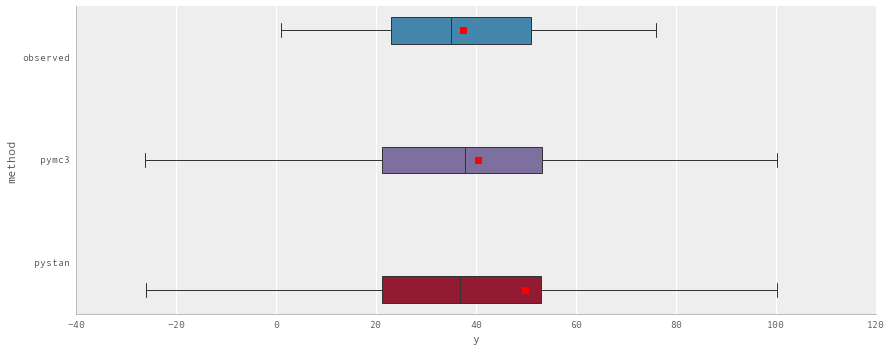

In [26]:
g = sns.factorplot(x='y', y='method', hue='method',
                   data=df_yhat_mean_melt, kind='box', size=5, aspect=2.5,
                   legend=False, showmeans=True, sym='')

## Eyeballing: Calculate Coverage

In [28]:
def ppc_coverage(yhat, mx_en, cr=.5):
    """ calc the proportion of coverage from full yhat ppc (nobservations x nsamples)"""

    lower_bound = np.percentile(yhat, 50 - (50 * cr), axis=1)
    upper_bound = np.percentile(yhat, 50 + (50 * cr), axis=1)
    ninliers = np.sum((mx_en.values.T >= lower_bound).T & (mx_en.values.T <= upper_bound).T)
    
    return ninliers / mx_en.shape[0]

In [34]:
dfcov = pd.DataFrame({'cr': np.arange(0, 1.01, .05)})
dfcov['coverage_pymc'] = dfcov['cr'].apply(lambda x: ppc_coverage(yhat_pymc, mx_en, cr=x))
dfcov['coverage_pystan'] = dfcov['cr'].apply(lambda x: ppc_coverage(yhat_pystan, mx_en, cr=x))

In [39]:
dfcov_melt = pd.melt(dfcov, id_vars='cr', var_name='model', value_name='coverage')

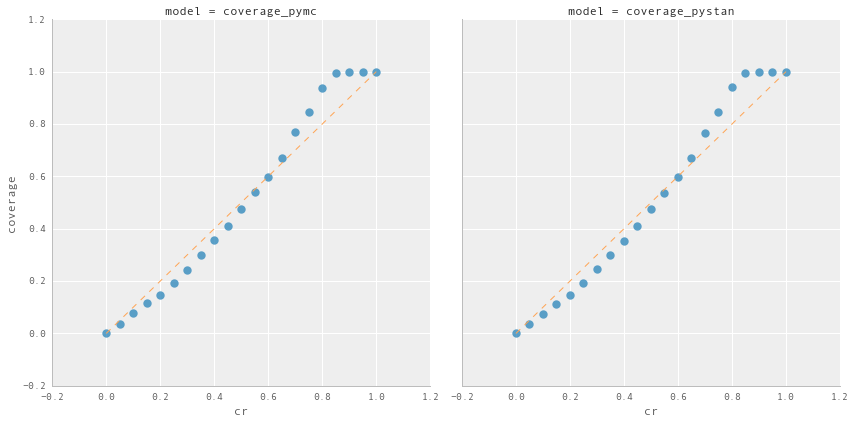

In [42]:
g = sns.lmplot(x='cr', y='coverage', col='model', data=dfcov_melt, fit_reg=False,
               size=6, scatter_kws={'s':70})
_ = [g.axes[0][i].plot((0,1),(0,1),ls='--',color='#FFA555') for i in range(2)]

**Observe:**

The coverage seems fairly poor:
+ Slight under-coverage at narrow CR 
+ Strong over-coverage at wide CR, particularly above 0.8
+ The over-coverage at wide CR indicates the model might be overly influenced by outliers

## Compute Mean-Squared Error (MSE)

Mean-Squared Error of prediction vs observed $$\frac{1}{n}\sum_{i=1}^{i=n}(\hat{y}_{i}-y_{i})^{2}$$

In [43]:
def compute_mse(observed, yhat_dist):
    return np.sum((observed - yhat_dist.mean(1))**2) / len(observed)

##### PyMC3 model MSE

In [44]:
compute_mse(mx_en[ft_endog], yhat_pymc)

26140.064509482203

##### PyStan model MSE

In [45]:
compute_mse(mx_en[ft_endog], yhat_pystan)

143789.00082573877

## Compute R-squared

Since we have the MSE anyway, lets calculate the (unadjusted) r-squared ($R^{2}$) value for each model. It's a ratio of the sum of squared errors for the model and the sum of squared errors for a hypothetical model that just predicts the mean of the dataset. 

$$R^{2} = 1 - \frac{\sum e_{model}^{2}}{\sum e_{mean}^{2}}$$

Ideally the $R^{2}$ lives in the range $[0,1]$, but in practice, it's quite easy for a model to perform arbitrily worse than the mean guess, particularly for oddly shaped data, resulting in a possible range (-inf, 1]



In [46]:
def compute_r2(observed, yhat_dist):
    
    sse_model = np.sum((observed - yhat_dist.mean(1))**2)
    sse_mean = np.sum((observed - observed.mean())**2)
    
    return 1 - (sse_model / sse_mean)

##### PyMC3 model R2

In [47]:
compute_r2(mx_en[ft_endog], yhat_pymc)

-80.591101952395036

##### PyStan model R2

In [48]:
compute_r2(mx_en[ft_endog], yhat_pystan)

-447.80926065619184

## Compute Kolmogorov–Smirnov (KS) Test

Mean values / Max Likelihoods are a clumsy way to summarise data, wasting lots of rich information present in our carefully gathered Bayesian samples.

Instead of summarising to calcuate MSE and $R^{2}$, lets compare the _distributions_ of the predicted values $\hat{y}$ vs the actual values $y$

I'll use the [Kolmogorov-Smirnov (KS) Test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test), specifically the 2-sample version, which lets us quantify the distance between the empirical distribution functions of two 'samples': the model predictions in this case.

##### Using `scipy.stats.ks_2samp`

As per the [docs](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.ks_2samp.html), this is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same. For my purposes here, I'm simply looking for mutual differences between the posterior predictive distibutions for the `pymc3` and `pystan` yhats, and their individual differences with the `observed` distribution

In [49]:
for (a,b) in combinations(['observed','pymc3','pystan'], 2):
    print('\n{} vs {}:'.format(a,b))
    print(ks_2samp(df_yhat[a].values, df_yhat[b].values))


observed vs pymc3:
Ks_2sampResult(statistic=0.083686849209409941, pvalue=2.2920448851288229e-08)

observed vs pystan:
Ks_2sampResult(statistic=0.09409949865021211, pvalue=1.8248854176675423e-10)

pymc3 vs pystan:
Ks_2sampResult(statistic=0.018897030466640929, pvalue=0.73972718941801741)


**Observe:**

The first 3 results printed above show the difference between the `observed` distribution and the posterior predictive distribution for `pymc3`, and `pystan` models

+ The KS statistics for the two pairs `observed` vs `pymc3`, and `observed` vs `pystan` are fairly similar, which agrees with what we saw in the mean distrobution plots earlier
+ The KS statistic for the final pair `pymc3` vs `pystan` is a little smaller and the p-value far higher, also suggesting that the `pymc3` and `pystan` models have fitted the data quite similarly - which is what we would hope to see!
+ This is amore detailled look than was possible when just using the MSE and R2 checks.

---
**&copy; Applied AI Ltd 2016**  
<a href='http://www.applied.ai'>applied.ai</a>